In [56]:
!pip install matplotlib==3.3.4

  Using cached matplotlib-3.3.4-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


In [66]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import cv2
import random
# import torchaudio

In [52]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [16]:
X, sample_rate = librosa.load('aihub/5e2aefca5807b852d9e021e0.wav', res_type='kaiser_fast',sr=16000,offset=0.5)
addAWGN(X)[0].shape
X.shape

(69142,)

In [17]:
labels=[]
for i in range(len(sw_list)):
    i = sw_list[i]
    if i[6:7] =='a':
        label = 'angry'
    elif i[6:7] =='n':
        label = 'neutral'
    elif i[6:7] =='s':
        label = 'sadness'
    elif i[6:7] =='h':
        label = 'happiness'
    labels.append(label)

NameError: name 'sw_list' is not defined

In [18]:
dicto = {'path' : sw_list, 'emotion' : labels}
df2 = pd.DataFrame(dicto)

NameError: name 'sw_list' is not defined

In [19]:
mylist_1= os.listdir('aihub/')
type(mylist_1)
mylist=[]
for item in mylist_1:
    if item[-3:]=='wav':
        mylist.append(item)
df = pd.read_csv('./aihub/AIhub.csv')
df = pd.concat([df,df2],ignore_index=True)

NameError: name 'df2' is not defined

In [20]:
df =df.reset_index(drop=True)

In [21]:
#wav2spec
class ETRIDataset_spectram_ai():
    def __init__(self, dataframe, frame_length=0.025, frame_stride=0.010):
        self.dataframe = dataframe
        self.frame_length = frame_length
        self.frame_stride = frame_stride
    
    def __len__(self):
        return len(self.dataframe)*3

    def __getitem__(self,index):
        if index<len(self.dataframe):
            audio_path = self.dataframe['path'][index]
            X, sample_rate = librosa.load('aihub/'+audio_path[6:], res_type='kaiser_fast',sr=16000,offset=0.5)
        elif index < len(self.dataframe)*2:
            audio_path = self.dataframe['path'][index-len(self.dataframe)]
            X, sample_rate = librosa.load('aihub/'+audio_path[6:], res_type='kaiser_fast',sr=16000,offset=0.5)
            X = addAWGN(X)[0]
        else:
            audio_path = self.dataframe['path'][index-len(self.dataframe)*2]
            X, sample_rate = librosa.load('aihub/'+audio_path[6:], res_type='kaiser_fast',sr=16000,offset=0.5)
            X = addAWGN(X)[1]
            
        sample_rate = sample_rate
        input_nfft = int(round(sample_rate*self.frame_length))
        input_stride = int(round(sample_rate*self.frame_stride))

        S = librosa.feature.melspectrogram(y=X, n_mels=64, n_fft=input_nfft, hop_length=input_stride)
        P = librosa.power_to_db(S, ref=np.max)
        

        ## get label
        if index < len(self.dataframe):
            if audio_path[-3:] == 'wav':
                if self.dataframe['emotion'][index] == 'angry':
                    label = 0
                elif self.dataframe['emotion'][index] == 'neutral':
                    label = 1
                elif self.dataframe['emotion'][index] == 'sadness':
                    label = 2
                elif self.dataframe['emotion'][index] == 'happiness':
                    label = 3
            else:
                label=None
        elif index < len(self.dataframe)*2:
            if audio_path[-3:] == 'wav':
                if self.dataframe['emotion'][index-len(self.dataframe)] == 'angry':
                    label = 0
                elif self.dataframe['emotion'][index-len(self.dataframe)] == 'neutral':
                    label = 1
                elif self.dataframe['emotion'][index-len(self.dataframe)] == 'sadness':
                    label = 2
                elif self.dataframe['emotion'][index-len(self.dataframe)] == 'happiness':
                    label = 3
            else:
                label=None
        else:
            if audio_path[-3:] == 'wav':
                if self.dataframe['emotion'][index-len(self.dataframe)*2] == 'angry':
                    label = 0
                elif self.dataframe['emotion'][index-len(self.dataframe)*2] == 'neutral':
                    label = 1
                elif self.dataframe['emotion'][index-len(self.dataframe)*2] == 'sadness':
                    label = 2
                elif self.dataframe['emotion'][index-len(self.dataframe)*2] == 'happiness':
                    label = 3
            else:
                label=None
        return P, label

In [22]:
# train,test,val split
train_size = int(0.7*len(df)*3)

val_size = int(0.2*len(df)*3)
test_size = int(len(df)*3-train_size-val_size)
train_set, val_set, test_set = torch.utils.data.random_split(ETRIDataset_spectram_ai(df),[train_size,val_size,test_size])
print(train_size)
print(val_size)
print(test_size)

4609
1317
659


In [25]:
df['emotion'][2100] == 'angry'

False

In [67]:
df

,path,emotion
0,./4y1/5e367ec8ee8206179943c051.wav,angry
1,./4y1/5e37d20fc8c25f16cd145708.wav,angry
2,./4y1/5e36610e7995ef170fc0e868.wav,angry
3,./4y1/5e41317c0b3f160367c2075c.wav,angry
4,./4y1/5e426f780b3f160367c2097d.wav,angry
...,...,...
2190,./5y2/5f7124ddf8fac448cc0a6229.wav,sadness
2191,./4y1/5e33ce7b5807b852d9e0580f.wav,sadness
2192,./4y1/5e43a429189842034d9f77a7.wav,sadness
2193,./4y1/5e44f7f0f2fe7a3b1d544784.wav,sadness


In [86]:
# spec2img
def getimg(dataset,feature):
        img_path=[]
        labels=[]
        for i in range(len(dataset)):
                # fig = plt.figure()
                # ax = fig.add_subplot(111)
                fig, ax = plt.subplots()
                p = librosa.display.specshow(dataset[i][0],ax=ax, sr=16000, hop_length=int(round(16000*0.025)), x_axis='time',y_axis='linear')
                extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

                fig.savefig('./image_aihub/%s_%d_%s.jpg' % (dataset[i][1],i,feature), bbox_inches=extent)
                img_path.append('./image_aihub/%s_%d_%s.jpg' % (dataset[i][1],i,feature))
                labels.append(dataset[i][1])
                plt.ioff()
                plt.close()
        return img_path , labels


TypeError: __init__() got an unexpected keyword argument 'basey'

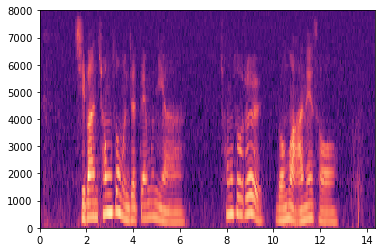

In [80]:
train_path , train_labels = getimg(train_set,'train')
val_path , val_labels = getimg(val_set,'val')
test_path , test_labels = getimg(test_set,'test')

In [220]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
                                                           

In [221]:
class img2tensor():
    def __init__(self,data_path,labels,transforms):
        self.data_path = data_path
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.data_path)

        
    def __getitem__(self, index):
        img_path = self.data_path[index]
        image = Image.open(img_path)
        I = train_transforms(image)
        label = self.labels[index]

        return I, label
        
        

In [222]:
# set batch_size
batch_size = 16
# dataloader
train_dataloader = torch.utils.data.DataLoader(img2tensor(train_path,train_labels,train_transforms), batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(img2tensor(val_path,val_labels,test_transforms), batch_size=batch_size, shuffle=False)
dataloaders_dict ={'train':train_dataloader, 'val': val_dataloader}
# test
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([16, 3, 224, 224])
tensor([0, 2, 1, 0, 1, 3, 1, 1, 2, 1, 3, 0, 0, 1, 0, 0])


In [263]:
# model = torchvision.models.densenet121(pretrained=True)
model = torchvision.models.resnet34(pretrained=True)
model.to(torch.device('cuda'))
# model.classifier = nn.Linear(in_features=1024, out_features=4)
model.classifier = nn.Linear(in_features=1000, out_features=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters() ,lr=0.00001, weight_decay=1e-6, momentum=0.9)
model.train()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/seojungin/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 23.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [264]:
def train(net, dataloader, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)
    torch.backends.cudnn.benchmark = True

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-------------------------------')

        for phase in ['train','val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and(phase == 'train'):
                continue
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs,1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() *inputs.size(0)

                    epoch_corrects += torch.sum(preds == labels.data)

                    epoch_loss = epoch_loss / len(dataloader[phase].dataset)
                    epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)


            print('{} Loss: {:.4f} ACC {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                

In [265]:
train(model, dataloaders_dict, criterion,optimizer, num_epochs=200)

cuda:0
Epoch 1/200
-------------------------------


100%|██████████| 86/86 [00:04<00:00, 21.33it/s]


val Loss: 0.0779 ACC 0.0000
Epoch 2/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.34it/s]


train Loss: 0.0033 ACC 0.3797


100%|██████████| 86/86 [00:03<00:00, 23.11it/s]


val Loss: 0.0097 ACC 0.4139
Epoch 3/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.43it/s]


train Loss: 0.0026 ACC 0.4404


100%|██████████| 86/86 [00:03<00:00, 22.67it/s]


val Loss: 0.0086 ACC 0.4562
Epoch 4/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


train Loss: 0.0023 ACC 0.4714


100%|██████████| 86/86 [00:03<00:00, 23.13it/s]


val Loss: 0.0066 ACC 0.4584
Epoch 5/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0033 ACC 0.4946


100%|██████████| 86/86 [00:03<00:00, 23.29it/s]


val Loss: 0.0072 ACC 0.4920
Epoch 6/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0024 ACC 0.5090


100%|██████████| 86/86 [00:03<00:00, 23.22it/s]


val Loss: 0.0062 ACC 0.4956
Epoch 7/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.76it/s]


train Loss: 0.0031 ACC 0.5244


100%|██████████| 86/86 [00:03<00:00, 23.08it/s]


val Loss: 0.0078 ACC 0.4964
Epoch 8/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0030 ACC 0.5446


100%|██████████| 86/86 [00:03<00:00, 23.07it/s]


val Loss: 0.0088 ACC 0.5015
Epoch 9/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0028 ACC 0.5603


100%|██████████| 86/86 [00:03<00:00, 23.01it/s]


val Loss: 0.0073 ACC 0.5496
Epoch 10/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.74it/s]


train Loss: 0.0019 ACC 0.5713


100%|██████████| 86/86 [00:03<00:00, 22.85it/s]


val Loss: 0.0065 ACC 0.5810
Epoch 11/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.74it/s]


train Loss: 0.0029 ACC 0.5776


100%|██████████| 86/86 [00:03<00:00, 23.14it/s]


val Loss: 0.0068 ACC 0.5518
Epoch 12/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.67it/s]


train Loss: 0.0029 ACC 0.5922


100%|██████████| 86/86 [00:03<00:00, 23.44it/s]


val Loss: 0.0055 ACC 0.5474
Epoch 13/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0018 ACC 0.5976


100%|██████████| 86/86 [00:03<00:00, 22.96it/s]


val Loss: 0.0106 ACC 0.5591
Epoch 14/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0019 ACC 0.6036


100%|██████████| 86/86 [00:03<00:00, 22.98it/s]


val Loss: 0.0070 ACC 0.5613
Epoch 15/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0021 ACC 0.6297


100%|██████████| 86/86 [00:03<00:00, 22.95it/s]


val Loss: 0.0050 ACC 0.5876
Epoch 16/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0018 ACC 0.6305


100%|██████████| 86/86 [00:03<00:00, 22.83it/s]


val Loss: 0.0056 ACC 0.5781
Epoch 17/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0023 ACC 0.6418


100%|██████████| 86/86 [00:03<00:00, 23.02it/s]


val Loss: 0.0062 ACC 0.5504
Epoch 18/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0039 ACC 0.6455


100%|██████████| 86/86 [00:03<00:00, 23.14it/s]


val Loss: 0.0057 ACC 0.5905
Epoch 19/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0025 ACC 0.6457


100%|██████████| 86/86 [00:03<00:00, 22.91it/s]


val Loss: 0.0039 ACC 0.6307
Epoch 20/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0027 ACC 0.6626


100%|██████████| 86/86 [00:03<00:00, 22.24it/s]


val Loss: 0.0042 ACC 0.6234
Epoch 21/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.45it/s]


train Loss: 0.0026 ACC 0.6670


100%|██████████| 86/86 [00:03<00:00, 22.81it/s]


val Loss: 0.0070 ACC 0.5664
Epoch 22/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.62it/s]


train Loss: 0.0021 ACC 0.6804


100%|██████████| 86/86 [00:03<00:00, 23.22it/s]


val Loss: 0.0054 ACC 0.6387
Epoch 23/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0019 ACC 0.6952


100%|██████████| 86/86 [00:03<00:00, 22.91it/s]


val Loss: 0.0062 ACC 0.6241
Epoch 24/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0028 ACC 0.7077


100%|██████████| 86/86 [00:03<00:00, 23.14it/s]


val Loss: 0.0085 ACC 0.6095
Epoch 25/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0011 ACC 0.7035


100%|██████████| 86/86 [00:03<00:00, 22.97it/s]


val Loss: 0.0077 ACC 0.6102
Epoch 26/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0012 ACC 0.7100


100%|██████████| 86/86 [00:03<00:00, 22.04it/s]


val Loss: 0.0047 ACC 0.6431
Epoch 27/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0010 ACC 0.7221


100%|██████████| 86/86 [00:03<00:00, 23.47it/s]


val Loss: 0.0075 ACC 0.6423
Epoch 28/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.53it/s]


train Loss: 0.0014 ACC 0.7252


100%|██████████| 86/86 [00:03<00:00, 23.00it/s]


val Loss: 0.0047 ACC 0.6467
Epoch 29/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0016 ACC 0.7179


100%|██████████| 86/86 [00:03<00:00, 23.02it/s]


val Loss: 0.0026 ACC 0.6504
Epoch 30/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0011 ACC 0.7327


100%|██████████| 86/86 [00:03<00:00, 22.97it/s]


val Loss: 0.0061 ACC 0.6686
Epoch 31/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.81it/s]


train Loss: 0.0008 ACC 0.7465


100%|██████████| 86/86 [00:03<00:00, 23.15it/s]


val Loss: 0.0042 ACC 0.6810
Epoch 32/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0024 ACC 0.7469


100%|██████████| 86/86 [00:03<00:00, 23.24it/s]


val Loss: 0.0093 ACC 0.6635
Epoch 33/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0024 ACC 0.7442


100%|██████████| 86/86 [00:03<00:00, 22.72it/s]


val Loss: 0.0023 ACC 0.6818
Epoch 34/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0024 ACC 0.7540


100%|██████████| 86/86 [00:03<00:00, 22.66it/s]


val Loss: 0.0038 ACC 0.6869
Epoch 35/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


train Loss: 0.0030 ACC 0.7673


100%|██████████| 86/86 [00:03<00:00, 21.82it/s]


val Loss: 0.0042 ACC 0.6876
Epoch 36/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.67it/s]


train Loss: 0.0023 ACC 0.7529


100%|██████████| 86/86 [00:03<00:00, 22.34it/s]


val Loss: 0.0048 ACC 0.7022
Epoch 37/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0016 ACC 0.7656


100%|██████████| 86/86 [00:03<00:00, 22.77it/s]


val Loss: 0.0044 ACC 0.6920
Epoch 38/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.58it/s]


train Loss: 0.0025 ACC 0.7771


100%|██████████| 86/86 [00:03<00:00, 22.91it/s]


val Loss: 0.0024 ACC 0.7153
Epoch 39/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.62it/s]


train Loss: 0.0016 ACC 0.7832


100%|██████████| 86/86 [00:03<00:00, 22.37it/s]


val Loss: 0.0031 ACC 0.7146
Epoch 40/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0008 ACC 0.7923


100%|██████████| 86/86 [00:03<00:00, 23.23it/s]


val Loss: 0.0043 ACC 0.6701
Epoch 41/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0007 ACC 0.7769


100%|██████████| 86/86 [00:03<00:00, 23.14it/s]


val Loss: 0.0033 ACC 0.6985
Epoch 42/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0004 ACC 0.7869


100%|██████████| 86/86 [00:03<00:00, 22.56it/s]


val Loss: 0.0028 ACC 0.7088
Epoch 43/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.51it/s]


train Loss: 0.0015 ACC 0.7921


100%|██████████| 86/86 [00:03<00:00, 23.49it/s]


val Loss: 0.0049 ACC 0.7131
Epoch 44/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0013 ACC 0.7936


100%|██████████| 86/86 [00:03<00:00, 23.07it/s]


val Loss: 0.0055 ACC 0.7270
Epoch 45/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.73it/s]


train Loss: 0.0015 ACC 0.7871


100%|██████████| 86/86 [00:03<00:00, 22.95it/s]


val Loss: 0.0042 ACC 0.7190
Epoch 46/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.83it/s]


train Loss: 0.0009 ACC 0.8015


100%|██████████| 86/86 [00:03<00:00, 23.39it/s]


val Loss: 0.0057 ACC 0.6825
Epoch 47/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0018 ACC 0.8028


100%|██████████| 86/86 [00:03<00:00, 22.93it/s]


val Loss: 0.0063 ACC 0.7248
Epoch 48/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0012 ACC 0.8061


100%|██████████| 86/86 [00:03<00:00, 23.46it/s]


val Loss: 0.0045 ACC 0.7416
Epoch 49/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0015 ACC 0.8103


100%|██████████| 86/86 [00:03<00:00, 22.63it/s]


val Loss: 0.0052 ACC 0.7161
Epoch 50/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.52it/s]


train Loss: 0.0010 ACC 0.8159


100%|██████████| 86/86 [00:03<00:00, 22.79it/s]


val Loss: 0.0040 ACC 0.7350
Epoch 51/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.56it/s]


train Loss: 0.0018 ACC 0.8169


100%|██████████| 86/86 [00:03<00:00, 22.93it/s]


val Loss: 0.0052 ACC 0.7285
Epoch 52/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0007 ACC 0.8180


100%|██████████| 86/86 [00:03<00:00, 23.11it/s]


val Loss: 0.0028 ACC 0.7350
Epoch 53/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0017 ACC 0.8180


100%|██████████| 86/86 [00:03<00:00, 22.95it/s]


val Loss: 0.0022 ACC 0.7511
Epoch 54/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0031 ACC 0.8265


100%|██████████| 86/86 [00:03<00:00, 23.12it/s]


val Loss: 0.0055 ACC 0.7175
Epoch 55/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0010 ACC 0.8209


100%|██████████| 86/86 [00:03<00:00, 22.84it/s]


val Loss: 0.0016 ACC 0.7350
Epoch 56/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0010 ACC 0.8169


100%|██████████| 86/86 [00:03<00:00, 23.05it/s]


val Loss: 0.0021 ACC 0.7438
Epoch 57/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.62it/s]


train Loss: 0.0003 ACC 0.8322


100%|██████████| 86/86 [00:03<00:00, 23.08it/s]


val Loss: 0.0069 ACC 0.7693
Epoch 58/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0013 ACC 0.8240


100%|██████████| 86/86 [00:03<00:00, 23.02it/s]


val Loss: 0.0022 ACC 0.7679
Epoch 59/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.64it/s]


train Loss: 0.0011 ACC 0.8367


100%|██████████| 86/86 [00:04<00:00, 21.46it/s]


val Loss: 0.0084 ACC 0.7299
Epoch 60/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0010 ACC 0.8253


100%|██████████| 86/86 [00:03<00:00, 23.26it/s]


val Loss: 0.0036 ACC 0.7635
Epoch 61/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


train Loss: 0.0014 ACC 0.8374


100%|██████████| 86/86 [00:03<00:00, 22.83it/s]


val Loss: 0.0048 ACC 0.7672
Epoch 62/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.50it/s]


train Loss: 0.0013 ACC 0.8422


100%|██████████| 86/86 [00:03<00:00, 21.82it/s]


val Loss: 0.0041 ACC 0.7555
Epoch 63/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.50it/s]


train Loss: 0.0021 ACC 0.8255


100%|██████████| 86/86 [00:03<00:00, 22.30it/s]


val Loss: 0.0011 ACC 0.7715
Epoch 64/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0013 ACC 0.8390


100%|██████████| 86/86 [00:03<00:00, 22.62it/s]


val Loss: 0.0074 ACC 0.7591
Epoch 65/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0009 ACC 0.8369


100%|██████████| 86/86 [00:03<00:00, 22.75it/s]


val Loss: 0.0021 ACC 0.7438
Epoch 66/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0018 ACC 0.8474


100%|██████████| 86/86 [00:03<00:00, 22.70it/s]


val Loss: 0.0019 ACC 0.7642
Epoch 67/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.67it/s]


train Loss: 0.0004 ACC 0.8442


100%|██████████| 86/86 [00:03<00:00, 23.37it/s]


val Loss: 0.0024 ACC 0.7766
Epoch 68/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0013 ACC 0.8424


100%|██████████| 86/86 [00:03<00:00, 23.13it/s]


val Loss: 0.0041 ACC 0.7599
Epoch 69/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0001 ACC 0.8488


100%|██████████| 86/86 [00:03<00:00, 23.38it/s]


val Loss: 0.0058 ACC 0.7679
Epoch 70/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train Loss: 0.0016 ACC 0.8486


100%|██████████| 86/86 [00:03<00:00, 22.74it/s]


val Loss: 0.0038 ACC 0.7701
Epoch 71/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0009 ACC 0.8532


100%|██████████| 86/86 [00:03<00:00, 23.17it/s]


val Loss: 0.0021 ACC 0.7985
Epoch 72/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.43it/s]


train Loss: 0.0010 ACC 0.8482


100%|██████████| 86/86 [00:03<00:00, 23.17it/s]


val Loss: 0.0025 ACC 0.7606
Epoch 73/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.75it/s]


train Loss: 0.0010 ACC 0.8511


100%|██████████| 86/86 [00:03<00:00, 23.13it/s]


val Loss: 0.0036 ACC 0.7803
Epoch 74/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0003 ACC 0.8490


100%|██████████| 86/86 [00:03<00:00, 23.10it/s]


val Loss: 0.0046 ACC 0.7540
Epoch 75/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.74it/s]


train Loss: 0.0008 ACC 0.8545


100%|██████████| 86/86 [00:03<00:00, 22.83it/s]


val Loss: 0.0029 ACC 0.7927
Epoch 76/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0006 ACC 0.8686


100%|██████████| 86/86 [00:03<00:00, 22.84it/s]


val Loss: 0.0023 ACC 0.7883
Epoch 77/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.58it/s]


train Loss: 0.0009 ACC 0.8547


100%|██████████| 86/86 [00:03<00:00, 23.06it/s]


val Loss: 0.0042 ACC 0.7861
Epoch 78/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0004 ACC 0.8684


100%|██████████| 86/86 [00:03<00:00, 22.77it/s]


val Loss: 0.0024 ACC 0.7584
Epoch 79/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


train Loss: 0.0011 ACC 0.8582


100%|██████████| 86/86 [00:03<00:00, 22.60it/s]


val Loss: 0.0051 ACC 0.7876
Epoch 80/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0011 ACC 0.8545


100%|██████████| 86/86 [00:03<00:00, 22.63it/s]


val Loss: 0.0009 ACC 0.7788
Epoch 81/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.59it/s]


train Loss: 0.0015 ACC 0.8599


100%|██████████| 86/86 [00:03<00:00, 23.26it/s]


val Loss: 0.0067 ACC 0.7679
Epoch 82/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0004 ACC 0.8584


100%|██████████| 86/86 [00:03<00:00, 23.27it/s]


val Loss: 0.0050 ACC 0.7956
Epoch 83/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0004 ACC 0.8674


100%|██████████| 86/86 [00:03<00:00, 23.37it/s]


val Loss: 0.0034 ACC 0.7788
Epoch 84/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.47it/s]


train Loss: 0.0010 ACC 0.8688


100%|██████████| 86/86 [00:03<00:00, 23.15it/s]


val Loss: 0.0046 ACC 0.7796
Epoch 85/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.45it/s]


train Loss: 0.0013 ACC 0.8695


100%|██████████| 86/86 [00:03<00:00, 23.20it/s]


val Loss: 0.0052 ACC 0.7920
Epoch 86/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.58it/s]


train Loss: 0.0007 ACC 0.8697


100%|██████████| 86/86 [00:03<00:00, 23.25it/s]


val Loss: 0.0021 ACC 0.7956
Epoch 87/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.49it/s]


train Loss: 0.0008 ACC 0.8682


100%|██████████| 86/86 [00:03<00:00, 23.11it/s]


val Loss: 0.0008 ACC 0.8124
Epoch 88/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.62it/s]


train Loss: 0.0005 ACC 0.8616


100%|██████████| 86/86 [00:03<00:00, 22.97it/s]


val Loss: 0.0033 ACC 0.7985
Epoch 89/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.67it/s]


train Loss: 0.0007 ACC 0.8668


100%|██████████| 86/86 [00:03<00:00, 23.32it/s]


val Loss: 0.0018 ACC 0.7876
Epoch 90/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.57it/s]


train Loss: 0.0008 ACC 0.8670


100%|██████████| 86/86 [00:03<00:00, 22.28it/s]


val Loss: 0.0048 ACC 0.7774
Epoch 91/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0008 ACC 0.8764


100%|██████████| 86/86 [00:03<00:00, 22.99it/s]


val Loss: 0.0022 ACC 0.7934
Epoch 92/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.59it/s]


train Loss: 0.0007 ACC 0.8672


100%|██████████| 86/86 [00:03<00:00, 23.08it/s]


val Loss: 0.0047 ACC 0.7737
Epoch 93/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.49it/s]


train Loss: 0.0008 ACC 0.8680


100%|██████████| 86/86 [00:03<00:00, 22.20it/s]


val Loss: 0.0014 ACC 0.8139
Epoch 94/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0010 ACC 0.8699


100%|██████████| 86/86 [00:03<00:00, 23.34it/s]


val Loss: 0.0017 ACC 0.8109
Epoch 95/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0007 ACC 0.8747


100%|██████████| 86/86 [00:03<00:00, 22.96it/s]


val Loss: 0.0032 ACC 0.8270
Epoch 96/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0006 ACC 0.8714


100%|██████████| 86/86 [00:03<00:00, 23.59it/s]


val Loss: 0.0021 ACC 0.8000
Epoch 97/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0011 ACC 0.8786


100%|██████████| 86/86 [00:03<00:00, 23.10it/s]


val Loss: 0.0024 ACC 0.8080
Epoch 98/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0001 ACC 0.8795


100%|██████████| 86/86 [00:03<00:00, 22.48it/s]


val Loss: 0.0043 ACC 0.8153
Epoch 99/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.55it/s]


train Loss: 0.0003 ACC 0.8818


100%|██████████| 86/86 [00:04<00:00, 21.24it/s]


val Loss: 0.0003 ACC 0.8000
Epoch 100/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.62it/s]


train Loss: 0.0007 ACC 0.8839


100%|██████████| 86/86 [00:03<00:00, 22.96it/s]


val Loss: 0.0022 ACC 0.8277
Epoch 101/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


train Loss: 0.0016 ACC 0.8761


100%|██████████| 86/86 [00:03<00:00, 23.08it/s]


val Loss: 0.0087 ACC 0.8036
Epoch 102/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0004 ACC 0.8816


100%|██████████| 86/86 [00:03<00:00, 23.26it/s]


val Loss: 0.0024 ACC 0.8109
Epoch 103/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0003 ACC 0.8853


100%|██████████| 86/86 [00:03<00:00, 22.94it/s]


val Loss: 0.0054 ACC 0.8000
Epoch 104/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.57it/s]


train Loss: 0.0005 ACC 0.8830


100%|██████████| 86/86 [00:03<00:00, 22.34it/s]


val Loss: 0.0025 ACC 0.7964
Epoch 105/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0012 ACC 0.8797


100%|██████████| 86/86 [00:03<00:00, 22.61it/s]


val Loss: 0.0002 ACC 0.7956
Epoch 106/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.67it/s]


train Loss: 0.0004 ACC 0.8876


100%|██████████| 86/86 [00:03<00:00, 23.10it/s]


val Loss: 0.0008 ACC 0.8080
Epoch 107/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.54it/s]


train Loss: 0.0012 ACC 0.8812


100%|██████████| 86/86 [00:03<00:00, 23.30it/s]


val Loss: 0.0021 ACC 0.7759
Epoch 108/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0021 ACC 0.8891


100%|██████████| 86/86 [00:03<00:00, 22.85it/s]


val Loss: 0.0055 ACC 0.8044
Epoch 109/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


train Loss: 0.0007 ACC 0.8882


100%|██████████| 86/86 [00:03<00:00, 23.35it/s]


val Loss: 0.0020 ACC 0.8066
Epoch 110/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.50it/s]


train Loss: 0.0004 ACC 0.8855


100%|██████████| 86/86 [00:03<00:00, 23.31it/s]


val Loss: 0.0013 ACC 0.7956
Epoch 111/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


train Loss: 0.0020 ACC 0.8907


100%|██████████| 86/86 [00:03<00:00, 22.56it/s]


val Loss: 0.0022 ACC 0.8044
Epoch 112/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0004 ACC 0.8910


100%|██████████| 86/86 [00:03<00:00, 22.90it/s]


val Loss: 0.0019 ACC 0.8109
Epoch 113/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0003 ACC 0.8937


100%|██████████| 86/86 [00:03<00:00, 23.02it/s]


val Loss: 0.0024 ACC 0.8321
Epoch 114/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.77it/s]


train Loss: 0.0001 ACC 0.8922


100%|██████████| 86/86 [00:03<00:00, 23.16it/s]


val Loss: 0.0060 ACC 0.8241
Epoch 115/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


train Loss: 0.0010 ACC 0.8872


100%|██████████| 86/86 [00:03<00:00, 22.53it/s]


val Loss: 0.0014 ACC 0.8007
Epoch 116/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


train Loss: 0.0006 ACC 0.8803


100%|██████████| 86/86 [00:03<00:00, 22.85it/s]


val Loss: 0.0024 ACC 0.8270
Epoch 117/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.52it/s]


train Loss: 0.0004 ACC 0.8964


100%|██████████| 86/86 [00:03<00:00, 23.17it/s]


val Loss: 0.0014 ACC 0.8015
Epoch 118/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.56it/s]


train Loss: 0.0007 ACC 0.8910


100%|██████████| 86/86 [00:03<00:00, 21.85it/s]


val Loss: 0.0025 ACC 0.8146
Epoch 119/200
-------------------------------


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


train Loss: 0.0010 ACC 0.8893


100%|██████████| 86/86 [00:03<00:00, 22.99it/s]


val Loss: 0.0046 ACC 0.8307
Epoch 120/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.64it/s]


train Loss: 0.0013 ACC 0.8962


100%|██████████| 86/86 [00:03<00:00, 22.85it/s]


val Loss: 0.0025 ACC 0.8007
Epoch 121/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


train Loss: 0.0009 ACC 0.8897


100%|██████████| 86/86 [00:03<00:00, 23.36it/s]


val Loss: 0.0017 ACC 0.8022
Epoch 122/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


train Loss: 0.0006 ACC 0.8907


100%|██████████| 86/86 [00:03<00:00, 22.88it/s]


val Loss: 0.0009 ACC 0.8270
Epoch 123/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.73it/s]


train Loss: 0.0008 ACC 0.8876


100%|██████████| 86/86 [00:03<00:00, 23.17it/s]


val Loss: 0.0011 ACC 0.8139
Epoch 124/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.79it/s]


train Loss: 0.0013 ACC 0.8941


100%|██████████| 86/86 [00:03<00:00, 22.93it/s]


val Loss: 0.0038 ACC 0.8051
Epoch 125/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0003 ACC 0.8970


100%|██████████| 86/86 [00:03<00:00, 23.09it/s]


val Loss: 0.0024 ACC 0.8029
Epoch 126/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.72it/s]


train Loss: 0.0002 ACC 0.8951


100%|██████████| 86/86 [00:03<00:00, 23.43it/s]


val Loss: 0.0044 ACC 0.8117
Epoch 127/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 14.08it/s]


train Loss: 0.0005 ACC 0.8999


100%|██████████| 86/86 [00:03<00:00, 22.49it/s]


val Loss: 0.0027 ACC 0.8204
Epoch 128/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.83it/s]


train Loss: 0.0004 ACC 0.8935


100%|██████████| 86/86 [00:03<00:00, 22.88it/s]


val Loss: 0.0018 ACC 0.8058
Epoch 129/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.95it/s]


train Loss: 0.0009 ACC 0.8949


100%|██████████| 86/86 [00:03<00:00, 22.42it/s]


val Loss: 0.0025 ACC 0.8197
Epoch 130/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 14.05it/s]


train Loss: 0.0010 ACC 0.8930


100%|██████████| 86/86 [00:03<00:00, 23.05it/s]


val Loss: 0.0029 ACC 0.8058
Epoch 131/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.85it/s]


train Loss: 0.0012 ACC 0.8943


100%|██████████| 86/86 [00:03<00:00, 22.71it/s]


val Loss: 0.0019 ACC 0.8204
Epoch 132/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 14.03it/s]


train Loss: 0.0007 ACC 0.9037


100%|██████████| 86/86 [00:03<00:00, 23.19it/s]


val Loss: 0.0037 ACC 0.8204
Epoch 133/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.86it/s]


train Loss: 0.0019 ACC 0.9022


100%|██████████| 86/86 [00:03<00:00, 22.38it/s]


val Loss: 0.0017 ACC 0.8109
Epoch 134/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.80it/s]


train Loss: 0.0013 ACC 0.9020


100%|██████████| 86/86 [00:03<00:00, 22.34it/s]


val Loss: 0.0016 ACC 0.8095
Epoch 135/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.86it/s]


train Loss: 0.0001 ACC 0.8935


100%|██████████| 86/86 [00:03<00:00, 23.47it/s]


val Loss: 0.0012 ACC 0.8212
Epoch 136/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.85it/s]


train Loss: 0.0002 ACC 0.9026


100%|██████████| 86/86 [00:03<00:00, 22.61it/s]


val Loss: 0.0062 ACC 0.8146
Epoch 137/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 14.03it/s]


train Loss: 0.0002 ACC 0.9016


100%|██████████| 86/86 [00:03<00:00, 21.99it/s]


val Loss: 0.0024 ACC 0.8153
Epoch 138/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.97it/s]


train Loss: 0.0006 ACC 0.8945


100%|██████████| 86/86 [00:03<00:00, 23.44it/s]


val Loss: 0.0023 ACC 0.8248
Epoch 139/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.98it/s]


train Loss: 0.0007 ACC 0.8989


100%|██████████| 86/86 [00:03<00:00, 23.52it/s]


val Loss: 0.0030 ACC 0.8219
Epoch 140/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.87it/s]


train Loss: 0.0001 ACC 0.9033


100%|██████████| 86/86 [00:03<00:00, 22.94it/s]


val Loss: 0.0021 ACC 0.8248
Epoch 141/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.93it/s]


train Loss: 0.0009 ACC 0.9068


100%|██████████| 86/86 [00:03<00:00, 23.12it/s]


val Loss: 0.0034 ACC 0.8197
Epoch 142/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.90it/s]


train Loss: 0.0000 ACC 0.9070


100%|██████████| 86/86 [00:03<00:00, 22.72it/s]


val Loss: 0.0043 ACC 0.8226
Epoch 143/200
-------------------------------


100%|██████████| 300/300 [00:21<00:00, 13.89it/s]


train Loss: 0.0008 ACC 0.8949


100%|██████████| 86/86 [00:03<00:00, 22.83it/s]


val Loss: 0.0035 ACC 0.8285
Epoch 144/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.35it/s]


train Loss: 0.0001 ACC 0.9014


100%|██████████| 86/86 [00:03<00:00, 23.35it/s]


val Loss: 0.0010 ACC 0.8102
Epoch 145/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.66it/s]


train Loss: 0.0012 ACC 0.9003


100%|██████████| 86/86 [00:03<00:00, 23.62it/s]


val Loss: 0.0010 ACC 0.8153
Epoch 146/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.45it/s]


train Loss: 0.0002 ACC 0.9066


100%|██████████| 86/86 [00:03<00:00, 22.55it/s]


val Loss: 0.0004 ACC 0.8234
Epoch 147/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.56it/s]


train Loss: 0.0007 ACC 0.8989


100%|██████████| 86/86 [00:03<00:00, 22.99it/s]


val Loss: 0.0029 ACC 0.8182
Epoch 148/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.95it/s]


train Loss: 0.0005 ACC 0.9143


100%|██████████| 86/86 [00:03<00:00, 23.36it/s]


val Loss: 0.0030 ACC 0.8328
Epoch 149/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.64it/s]


train Loss: 0.0001 ACC 0.9047


100%|██████████| 86/86 [00:03<00:00, 23.37it/s]


val Loss: 0.0036 ACC 0.8336
Epoch 150/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.58it/s]


train Loss: 0.0010 ACC 0.9060


100%|██████████| 86/86 [00:03<00:00, 24.03it/s]


val Loss: 0.0029 ACC 0.8380
Epoch 151/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.96it/s]


train Loss: 0.0002 ACC 0.9062


100%|██████████| 86/86 [00:03<00:00, 24.28it/s]


val Loss: 0.0061 ACC 0.8292
Epoch 152/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.96it/s]


train Loss: 0.0004 ACC 0.9014


100%|██████████| 86/86 [00:03<00:00, 24.12it/s]


val Loss: 0.0012 ACC 0.8270
Epoch 153/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.91it/s]


train Loss: 0.0003 ACC 0.9047


100%|██████████| 86/86 [00:03<00:00, 24.19it/s]


val Loss: 0.0014 ACC 0.8299
Epoch 154/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.81it/s]


train Loss: 0.0018 ACC 0.9160


100%|██████████| 86/86 [00:03<00:00, 24.05it/s]


val Loss: 0.0010 ACC 0.8285
Epoch 155/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.83it/s]


train Loss: 0.0013 ACC 0.9080


100%|██████████| 86/86 [00:03<00:00, 24.10it/s]


val Loss: 0.0024 ACC 0.8117
Epoch 156/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.90it/s]


train Loss: 0.0009 ACC 0.9010


100%|██████████| 86/86 [00:03<00:00, 24.11it/s]


val Loss: 0.0010 ACC 0.8212
Epoch 157/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.82it/s]


train Loss: 0.0006 ACC 0.9101


100%|██████████| 86/86 [00:03<00:00, 24.11it/s]


val Loss: 0.0029 ACC 0.8197
Epoch 158/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


train Loss: 0.0005 ACC 0.9095


100%|██████████| 86/86 [00:03<00:00, 24.12it/s]


val Loss: 0.0014 ACC 0.8292
Epoch 159/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.87it/s]


train Loss: 0.0012 ACC 0.9103


100%|██████████| 86/86 [00:03<00:00, 24.14it/s]


val Loss: 0.0030 ACC 0.8314
Epoch 160/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.80it/s]


train Loss: 0.0003 ACC 0.9120


100%|██████████| 86/86 [00:03<00:00, 23.87it/s]


val Loss: 0.0038 ACC 0.8248
Epoch 161/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.77it/s]


train Loss: 0.0003 ACC 0.9124


100%|██████████| 86/86 [00:03<00:00, 23.52it/s]


val Loss: 0.0075 ACC 0.8431
Epoch 162/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.56it/s]


train Loss: 0.0013 ACC 0.9135


100%|██████████| 86/86 [00:03<00:00, 23.83it/s]


val Loss: 0.0013 ACC 0.8460
Epoch 163/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.61it/s]


train Loss: 0.0012 ACC 0.9114


100%|██████████| 86/86 [00:03<00:00, 22.00it/s]


val Loss: 0.0020 ACC 0.8365
Epoch 164/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.70it/s]


train Loss: 0.0008 ACC 0.9078


100%|██████████| 86/86 [00:03<00:00, 23.27it/s]


val Loss: 0.0014 ACC 0.8336
Epoch 165/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.72it/s]


train Loss: 0.0015 ACC 0.9106


100%|██████████| 86/86 [00:03<00:00, 23.40it/s]


val Loss: 0.0023 ACC 0.8409
Epoch 166/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.72it/s]


train Loss: 0.0002 ACC 0.9089


100%|██████████| 86/86 [00:03<00:00, 23.48it/s]


val Loss: 0.0052 ACC 0.8365
Epoch 167/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.72it/s]


train Loss: 0.0006 ACC 0.9103


100%|██████████| 86/86 [00:03<00:00, 23.89it/s]


val Loss: 0.0045 ACC 0.8401
Epoch 168/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.52it/s]


train Loss: 0.0007 ACC 0.9085


100%|██████████| 86/86 [00:03<00:00, 23.40it/s]


val Loss: 0.0006 ACC 0.8248
Epoch 169/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.64it/s]


train Loss: 0.0000 ACC 0.9074


100%|██████████| 86/86 [00:03<00:00, 23.96it/s]


val Loss: 0.0015 ACC 0.8401
Epoch 170/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.68it/s]


train Loss: 0.0001 ACC 0.9181


100%|██████████| 86/86 [00:03<00:00, 23.64it/s]


val Loss: 0.0025 ACC 0.8182
Epoch 171/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.38it/s]


train Loss: 0.0001 ACC 0.9149


100%|██████████| 86/86 [00:03<00:00, 23.98it/s]


val Loss: 0.0019 ACC 0.8394
Epoch 172/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.60it/s]


train Loss: 0.0001 ACC 0.9160


100%|██████████| 86/86 [00:03<00:00, 23.98it/s]


val Loss: 0.0020 ACC 0.8182
Epoch 173/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.51it/s]


train Loss: 0.0007 ACC 0.9195


100%|██████████| 86/86 [00:03<00:00, 23.10it/s]


val Loss: 0.0001 ACC 0.8314
Epoch 174/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.67it/s]


train Loss: 0.0002 ACC 0.9183


100%|██████████| 86/86 [00:03<00:00, 24.04it/s]


val Loss: 0.0012 ACC 0.7985
Epoch 175/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.54it/s]


train Loss: 0.0005 ACC 0.9110


100%|██████████| 86/86 [00:03<00:00, 22.55it/s]


val Loss: 0.0041 ACC 0.8467
Epoch 176/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.66it/s]


train Loss: 0.0002 ACC 0.9126


100%|██████████| 86/86 [00:03<00:00, 23.61it/s]


val Loss: 0.0018 ACC 0.8299
Epoch 177/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.58it/s]


train Loss: 0.0005 ACC 0.9110


100%|██████████| 86/86 [00:03<00:00, 24.45it/s]


val Loss: 0.0011 ACC 0.8511
Epoch 178/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.89it/s]


train Loss: 0.0009 ACC 0.9122


100%|██████████| 86/86 [00:03<00:00, 24.19it/s]


val Loss: 0.0017 ACC 0.8401
Epoch 179/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.90it/s]


train Loss: 0.0009 ACC 0.9237


100%|██████████| 86/86 [00:03<00:00, 24.04it/s]


val Loss: 0.0009 ACC 0.8270
Epoch 180/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


train Loss: 0.0013 ACC 0.9164


100%|██████████| 86/86 [00:03<00:00, 24.21it/s]


val Loss: 0.0033 ACC 0.8372
Epoch 181/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.86it/s]


train Loss: 0.0007 ACC 0.9149


100%|██████████| 86/86 [00:03<00:00, 24.03it/s]


val Loss: 0.0095 ACC 0.8372
Epoch 182/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.87it/s]


train Loss: 0.0011 ACC 0.9135


100%|██████████| 86/86 [00:03<00:00, 24.02it/s]


val Loss: 0.0011 ACC 0.8577
Epoch 183/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.85it/s]


train Loss: 0.0004 ACC 0.9191


100%|██████████| 86/86 [00:03<00:00, 23.90it/s]


val Loss: 0.0011 ACC 0.8314
Epoch 184/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.91it/s]


train Loss: 0.0005 ACC 0.9283


100%|██████████| 86/86 [00:03<00:00, 23.59it/s]


val Loss: 0.0027 ACC 0.8234
Epoch 185/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.84it/s]


train Loss: 0.0010 ACC 0.9172


100%|██████████| 86/86 [00:03<00:00, 24.09it/s]


val Loss: 0.0042 ACC 0.8387
Epoch 186/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.79it/s]


train Loss: 0.0006 ACC 0.9101


100%|██████████| 86/86 [00:03<00:00, 24.23it/s]


val Loss: 0.0017 ACC 0.8599
Epoch 187/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.79it/s]


train Loss: 0.0013 ACC 0.9206


100%|██████████| 86/86 [00:03<00:00, 23.96it/s]


val Loss: 0.0060 ACC 0.8453
Epoch 188/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


train Loss: 0.0005 ACC 0.9162


100%|██████████| 86/86 [00:03<00:00, 24.22it/s]


val Loss: 0.0016 ACC 0.8343
Epoch 189/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.85it/s]


train Loss: 0.0005 ACC 0.9133


100%|██████████| 86/86 [00:03<00:00, 23.83it/s]


val Loss: 0.0056 ACC 0.8416
Epoch 190/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.89it/s]


train Loss: 0.0010 ACC 0.9208


100%|██████████| 86/86 [00:03<00:00, 24.07it/s]


val Loss: 0.0025 ACC 0.8416
Epoch 191/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.86it/s]


train Loss: 0.0009 ACC 0.9199


100%|██████████| 86/86 [00:03<00:00, 24.27it/s]


val Loss: 0.0017 ACC 0.8431
Epoch 192/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.83it/s]


train Loss: 0.0002 ACC 0.9239


100%|██████████| 86/86 [00:03<00:00, 23.47it/s]


val Loss: 0.0018 ACC 0.8467
Epoch 193/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.85it/s]


train Loss: 0.0002 ACC 0.9162


100%|██████████| 86/86 [00:03<00:00, 24.35it/s]


val Loss: 0.0020 ACC 0.8569
Epoch 194/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.87it/s]


train Loss: 0.0004 ACC 0.9239


100%|██████████| 86/86 [00:03<00:00, 24.16it/s]


val Loss: 0.0017 ACC 0.8401
Epoch 195/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.80it/s]


train Loss: 0.0009 ACC 0.9212


100%|██████████| 86/86 [00:03<00:00, 24.03it/s]


val Loss: 0.0025 ACC 0.8533
Epoch 196/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.89it/s]


train Loss: 0.0014 ACC 0.9233


100%|██████████| 86/86 [00:03<00:00, 24.16it/s]


val Loss: 0.0009 ACC 0.8336
Epoch 197/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.82it/s]


train Loss: 0.0001 ACC 0.9204


100%|██████████| 86/86 [00:03<00:00, 24.09it/s]


val Loss: 0.0005 ACC 0.8358
Epoch 198/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.89it/s]


train Loss: 0.0004 ACC 0.9164


100%|██████████| 86/86 [00:03<00:00, 24.21it/s]


val Loss: 0.0009 ACC 0.8460
Epoch 199/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.70it/s]


train Loss: 0.0004 ACC 0.9174


100%|██████████| 86/86 [00:03<00:00, 22.72it/s]


val Loss: 0.0020 ACC 0.8394
Epoch 200/200
-------------------------------


100%|██████████| 300/300 [00:20<00:00, 14.65it/s]


train Loss: 0.0003 ACC 0.9281


100%|██████████| 86/86 [00:03<00:00, 23.55it/s]

val Loss: 0.0022 ACC 0.8438


In [266]:
# save weight
save_path = './saved_models/ResNet34_img_aihub+custom+augmentaion.pth'
torch.save(model.state_dict(),save_path)

In [267]:
# load weight
load_path = './saved_models/ResNet34_img_aihub+custom+augmentaion.pth'
load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
# model = torchvision.models.densenet121(pretrained=True)
model = torchvision.models.resnet34(pretrained=True)
# first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
# first_conv_layer.extend(list(model.features))  
# model.features= nn.Sequential(*first_conv_layer )  
# model.classifier = nn.Linear(in_features=1024, out_features=4)
model.classifier = nn.Linear(in_features=1000, out_features=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters() ,lr=0.00001, weight_decay=1e-6, momentum=0.9)
model.eval()
model.load_state_dict(load_weights)

<All keys matched successfully>

In [268]:
class Predictor(object):
    def __init__(self, model, device ='cpu',  fp16=False ):
        self.model = model
        
        self.cls_name = {0:'angry', 1:'happy', 2:'sad', 3:'neutral'}
        self.device = device
        

    def predict(self, audio):
        
        audio_info = audio
        
        outputs = self.model(audio_info)
        probability = torch.softmax(outputs,1)
        probability = probability.squeeze()
        proba, idx = torch.max(probability, dim=0)
        emo_proba = proba.item()
        print(emo_proba)
        idx = idx.item()
        emo_label = self.cls_name[idx]
        print(emo_label)
        return emo_label



In [269]:
def swdata(emotion):
    swlist_1 = os.listdir('swdata/%s/' % emotion)
    type(swlist_1)
    swlist = []
    for item in swlist_1:
        if item[-3:] == 'wav':
            swlist.append('./swdata/%s/' % emotion + item)
    return swlist

In [270]:
sw_list = swdata('angry') + swdata('happy') + swdata('sad') + swdata('neutral')

random.shuffle(sw_list)

In [271]:
sw_list

['./swdata/angry/0102.wav',
 './swdata/sad/1001.wav',
 './swdata/neutral/0801.wav',
 './swdata/happy/1102.wav',
 './swdata/sad/0202.wav',
 './swdata/happy/0902.wav',
 './swdata/angry/0201.wav',
 './swdata/neutral/1001.wav',
 './swdata/happy/0402.wav',
 './swdata/sad/1101.wav',
 './swdata/sad/0601.wav',
 './swdata/neutral/0802.wav',
 './swdata/happy/0201.wav',
 './swdata/sad/0902.wav',
 './swdata/angry/0401.wav',
 './swdata/neutral/0401.wav',
 './swdata/neutral/1101.wav',
 './swdata/happy/0102.wav',
 './swdata/neutral/1002.wav',
 './swdata/sad/0502.wav',
 './swdata/happy/1001.wav',
 './swdata/sad/0501.wav',
 './swdata/happy/1002.wav',
 './swdata/sad/0801.wav',
 './swdata/neutral/0202.wav',
 './swdata/happy/0602.wav',
 './swdata/sad/0701.wav',
 './swdata/happy/0501.wav',
 './swdata/angry/0501.wav',
 './swdata/happy/0701.wav',
 './swdata/angry/0103.wav',
 './swdata/neutral/0201.wav',
 './swdata/happy/0502.wav',
 './swdata/neutral/0701.wav',
 './swdata/happy/0702.wav',
 './swdata/angry/070

In [272]:
#wav2spec
class swdata_spectram():
    def __init__(self, dataframe, frame_length=0.025, frame_stride=0.010):
        self.dataframe = dataframe
        self.frame_length = frame_length
        self.frame_stride = frame_stride
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,index):
        audio_path = self.dataframe[index]
        X, sample_rate = librosa.load(audio_path, res_type='kaiser_fast',sr=16000,offset=0.0)
        sample_rate = sample_rate
        input_nfft = int(round(sample_rate*self.frame_length))
        input_stride = int(round(sample_rate*self.frame_stride))

        S = librosa.feature.melspectrogram(y=X, n_mels=64, n_fft=input_nfft, hop_length=input_stride)
        P = librosa.power_to_db(S, ref=np.max)
        

        ## get label
        if audio_path[-3:] == 'wav':
            if audio_path[9:10] =='a':
                label = 0
            elif audio_path[9:10] =='n':
                label = 1
            elif audio_path[9:10] =='s':
                label = 2
            elif audio_path[9:10] =='h':
                label = 3
        else:
            label=None
        return P, label

In [273]:
test_swdata = swdata_spectram(sw_list)
label=None
test_path , test_labels = getimg(test_swdata,'test_sw')


In [274]:
test_path

['./image_aihub/0_0_test_sw.jpg',
 './image_aihub/2_1_test_sw.jpg',
 './image_aihub/1_2_test_sw.jpg',
 './image_aihub/3_3_test_sw.jpg',
 './image_aihub/2_4_test_sw.jpg',
 './image_aihub/3_5_test_sw.jpg',
 './image_aihub/0_6_test_sw.jpg',
 './image_aihub/1_7_test_sw.jpg',
 './image_aihub/3_8_test_sw.jpg',
 './image_aihub/2_9_test_sw.jpg',
 './image_aihub/2_10_test_sw.jpg',
 './image_aihub/1_11_test_sw.jpg',
 './image_aihub/3_12_test_sw.jpg',
 './image_aihub/2_13_test_sw.jpg',
 './image_aihub/0_14_test_sw.jpg',
 './image_aihub/1_15_test_sw.jpg',
 './image_aihub/1_16_test_sw.jpg',
 './image_aihub/3_17_test_sw.jpg',
 './image_aihub/1_18_test_sw.jpg',
 './image_aihub/2_19_test_sw.jpg',
 './image_aihub/3_20_test_sw.jpg',
 './image_aihub/2_21_test_sw.jpg',
 './image_aihub/3_22_test_sw.jpg',
 './image_aihub/2_23_test_sw.jpg',
 './image_aihub/1_24_test_sw.jpg',
 './image_aihub/3_25_test_sw.jpg',
 './image_aihub/2_26_test_sw.jpg',
 './image_aihub/3_27_test_sw.jpg',
 './image_aihub/0_28_test_sw.j

In [275]:
img2tensor(test_path,test_labels,test_transforms)[1][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [276]:
predictor = Predictor(model)
device='cpu'
a=[]
b=[]
for i in range(len(img2tensor(test_path,test_labels,test_transforms))):
    a.append(predictor.predict(img2tensor(test_path,test_labels,test_transforms)[i][0].unsqueeze(0)))
    b.append(img2tensor(test_path,test_labels,test_transforms)[i][1])


0.9992499947547913
angry
0.6637448072433472
sad
0.7515119910240173
sad
0.7910356521606445
neutral
0.9999866485595703
sad
0.9975740313529968
neutral
0.9059281945228577
angry
0.9909104704856873
happy
0.584356963634491
neutral
0.8786373138427734
sad
0.999591052532196
sad
0.6299387812614441
sad
0.6735338568687439
happy
0.8351410627365112
sad
0.6344221234321594
angry
0.9995591044425964
happy
0.9972520470619202
happy
0.9419590830802917
neutral
0.4528966546058655
neutral
0.9999350309371948
sad
0.9999998807907104
neutral
0.9994934797286987
sad
0.9999947547912598
neutral
0.999991774559021
sad
0.9999994039535522
happy
0.9999421834945679
neutral
0.9999967813491821
sad
0.9861142635345459
neutral
0.9999505281448364
angry
0.6701821088790894
neutral
0.8223038911819458
angry
0.9999768733978271
happy
0.9966351389884949
neutral
0.9999505281448364
happy
0.9986082911491394
neutral
0.9998520612716675
angry
0.7368167042732239
angry
0.6265462040901184
happy
0.6983428001403809
angry
0.9703207015991211
happy
0

In [277]:
df = pd.DataFrame(a,columns=['predict'])
df['original']=b
for i in range(len(df)):
    if df['original'][i] == 0:
        df['original'][i] = 'angry'
    elif df['original'][i] == 1:
        df['original'][i] = 'happy'
    elif df['original'][i] == 2:
        df['original'][i] = 'sad'
    elif df['original'][i] == 3:
        df['original'][i] = 'neutral'
print('accuracy={}'.format((df['predict']==df['original']).sum()/len(df)))

accuracy=0.8089887640449438


/tmp/ipykernel_7289/4207275683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original'][i] = 'angry'
/home/seojungin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [262]:
df.to_csv('predict_result_resnet34_img_sw_aihub+custom+augmentaion.csv',index=False)
